In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

csv_file_path = os.path.join(os.getcwd(), 'filtered_data.csv')
data = pd.read_csv(csv_file_path).iloc[::-1]

print(data.head())

    Exchange Date    Close    Net
332    2023-01-09  1056.41  23.41
331    2023-01-10  1057.60   1.19
330    2023-01-11  1061.51   3.91
329    2023-01-12  1063.11   1.60
328    2023-01-13  1074.82  11.71


## Process data 

In [59]:
data.dropna(inplace=True)
data.set_index('Exchange Date', inplace=True)
print(data.head())

                 Close    Net
Exchange Date                
2023-01-09     1056.41  23.41
2023-01-10     1057.60   1.19
2023-01-11     1061.51   3.91
2023-01-12     1063.11   1.60
2023-01-13     1074.82  11.71


## Scale Data

In [60]:
from sklearn.preprocessing import MinMaxScaler

print(data.head(), end='\n\n')
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)
print(data_set_scaled[:10])

                 Close    Net
Exchange Date                
2023-01-09     1056.41  23.41
2023-01-10     1057.60   1.19
2023-01-11     1061.51   3.91
2023-01-12     1063.11   1.60
2023-01-13     1074.82  11.71

[[0.61090306 0.97651788]
 [0.61820861 0.5064523 ]
 [0.64221254 0.56399408]
 [0.65203512 0.51512587]
 [0.72392412 0.7290036 ]
 [0.71618884 0.45462238]
 [0.70102523 0.42902475]
 [0.7316594  0.58684155]
 [0.7060593  0.39306114]
 [0.75928541 0.66469219]]


## Separating data in batches

In [69]:
X = []
# how many data points to look behind at before predicting
# 28 because its the average number of days in a month - can be modified
lookback = 28

# go trough every column 

for j in range(len(data_set_scaled[0])):
    X.append([])
    # go trough every data 
    for i in range(lookback, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-lookback:i, j])
        
X = np.moveaxis(X, [0], [2])
Y = np.array(data_set_scaled[lookback:, -1])
Y = np.reshape(Y, (len(Y), 1))

print(X[:2])
print(Y[:1])

[[[0.61090306 0.97651788]
  [0.61820861 0.5064523 ]
  [0.64221254 0.56399408]
  [0.65203512 0.51512587]
  [0.72392412 0.7290036 ]
  [0.71618884 0.45462238]
  [0.70102523 0.42902475]
  [0.7316594  0.58684155]
  [0.7060593  0.39306114]
  [0.75928541 0.66469219]
  [0.77426484 0.53289613]
  [0.77745718 0.4922784 ]
  [0.77494014 0.47260419]
  [0.84062865 0.70763698]
  [0.82472834 0.42648614]
  [0.78936706 0.35942458]
  [0.72189821 0.24878358]
  [0.78820063 0.70975249]
  [0.79378722 0.50052888]
  [0.74424458 0.31055638]
  [0.60457978 0.        ]
  [0.60869298 0.49545166]
  [0.63895881 0.58557224]
  [0.66443612 0.56907129]
  [0.59438885 0.23989846]
  [0.6078949  0.52781891]
  [0.60623734 0.4755659 ]
  [0.55159924 0.29299767]]

 [[0.61820861 0.5064523 ]
  [0.64221254 0.56399408]
  [0.65203512 0.51512587]
  [0.72392412 0.7290036 ]
  [0.71618884 0.45462238]
  [0.70102523 0.42902475]
  [0.7316594  0.58684155]
  [0.7060593  0.39306114]
  [0.75928541 0.66469219]
  [0.77426484 0.53289613]
  [0.77745

In [70]:
print(X.shape)
print(Y.shape)

(305, 28, 2)
(305, 1)


## Split data into train test sets

In [71]:
split = int(len(X) * 0.8)
X_train , X_test = X[:split], X[split:]
Y_train , Y_test = Y[:split], Y[split:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(244, 28, 2)
(61, 28, 2)
(244, 1)
(61, 1)


## LSTM Model

In [76]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(keras.__version__)

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
3.3.3


In [81]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

lstm_input = Input(shape=(lookback, len(data_set_scaled[0])), name='lstm_input')
inputs = LSTM(128, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation(keras.activations.leaky_relu, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=Y_train, batch_size=15, epochs=3, shuffle=True, validation_split=0.1)

Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0763 - val_loss: 0.0398
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0379 - val_loss: 0.0398
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0344 - val_loss: 0.0297


In [84]:
prediction = model.predict(X_test)
for i in range(len(prediction)):
    print(Y_test[i], prediction[i])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.79268035] [0.42912033]
[0.62534377] [0.45851493]
[0.41971652] [0.4765474]
[0.62090121] [0.47627822]
[0.27649672] [0.48724344]
[0.40765813] [0.47102585]
[0.58345674] [0.46142873]
[0.50264438] [0.46538007]
[0.41654326] [0.46552113]
[0.85487624] [0.45954403]
[0.49629786] [0.48679227]
[0.35498202] [0.48979363]
[0.41908187] [0.47960877]
[0.48741274] [0.4712941]
[0.45568014] [0.46782136]
[0.57689867] [0.46305856]
[0.65919188] [0.46822652]
[0.44764121] [0.4807553]
[0.60228475] [0.4787565]
[0.52549186] [0.48703724]
[0.65919188] [0.48974773]
[0.46160355] [0.5019419]
[0.41760102] [0.4994191]
[0.59551513] [0.49165836]
[0.2534377] [0.49605885]
[0.53014597] [0.47588468]
[0.56103237] [0.4745977]
[0.61455469] [0.4777175]
[0.33700021] [0.48672548]
[0.65813412] [0.47583106]
[0.55214724] [0.48699388]
[0.62576687] [0.49191445]
[0.50285593] [0.5022038]
[0.66617305] [0.50309193]
[0.40067696] [0.514796]
[0.52083774] [0.5067425]
[0.52041464] [0.5054107]
[0.27755447] [

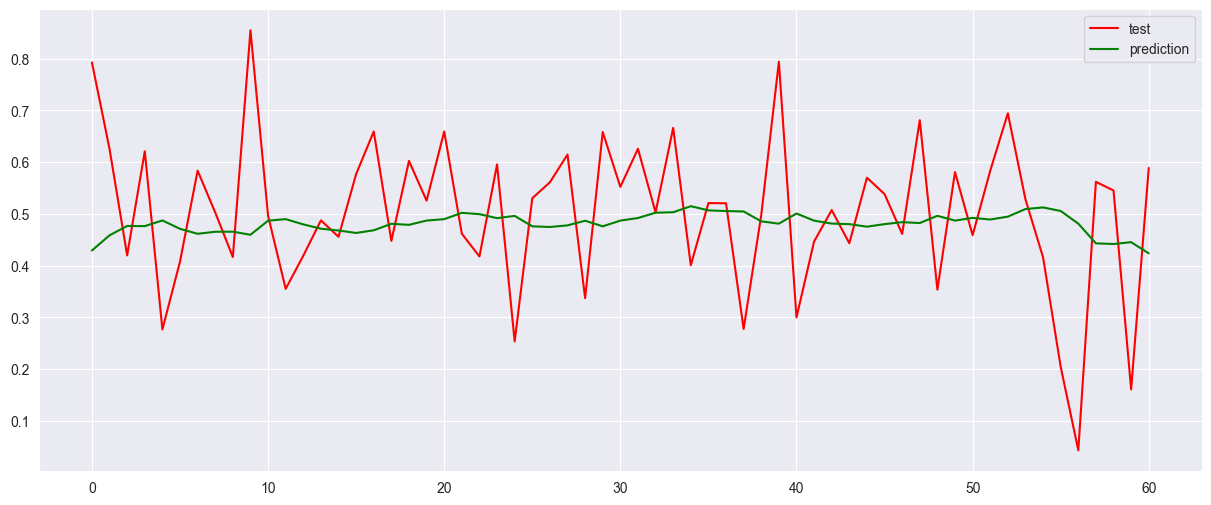

In [85]:
plt.figure(figsize=(15,6))
plt.plot(Y_test, color='red', label='test')
plt.plot(prediction, color='green', label='prediction')
plt.legend()
plt.show()